# Document Classification Pipeline


### Data prepossessing

`reuters_data` comes in two flavours: json and sgm. Although we were not allowed to use json data, a comparison of prepossessing of both data sets was compiled. json was easier to use, as it is structured as a dictionary: one can access the desirable field via key:value pair. Also, due to the nature of processing data in sgm format, the time complexity rises dramatically, when dealing with sgms. BS4 has to read-in and search all the required tags, then they are cleaned with regex. One can also create a class `ReutersParser`, where end and start tags are stored as booleans and make it more efficient, yet this method was not used. A decision had to be made how to deal with multi-labels and NaNs. One of the options was to process only the first label of the list, second option was to use `MulitLabelBinarizer()`. First option was chosen, however, it also impacted the models' ability to predict data in real-world: if it's trained only on one label, it can predict only one as well. Finally, ideally the data would be shuffled, but in this design it is not.

**Newsgorups**
As `newsgroups_data` is part of sklearn utilities, it has many pre-defined functionalities, which come in handy: shuffling, `target_names` and others are available as attributes. Unlike \path{reuters_data}, the classes in this dataset are less numerous, more balanced and there are none tags with missing data. Thus, the model has more to train on, which allegedly will yield higher accuracy as compared to Reuters data set.

**Data splitting**
For both data sets two versions of data splitting were used, 90/10 and 80/20, respectively.

**Feature extraction**
For all three models and both data sets `CountVectorizer()` and `TfIdfTransformer()` were chosen. As best practice dictates, stop-words were eliminated from the data. Initially bi-grams were used, however, after evaluating different parameters, uni-grams were chosen, as it resulted in higher accuracy. There was no need for either pre-tokenization or parsing because it is automatically done by CountVectorizer.


In [1]:
import numpy as np
from timeit import default_timer as timer
import os
import re
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import path

%matplotlib inline

Followed this cheat_sheet: https://intellipaat.com/mediaFiles/2018/12/Sklearn-cheat-sheet.png

**DATA**

1. Reuters. 
   1. a) json: More infromation at: https://github.com/mihaibogdan10/json-reuters-21578
   1. b) sgm: More infromation at: http://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html
2. Newsgroups. More infromation at: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

## 1. Loading data: REUTERS

### 1. 1 json version

In [2]:
def from_json(path_name):
    corpus, json_dict, index = list(), dict(), 0
    title_list = [title for title in os.listdir(path_name) if title.endswith('.json')]
    for title in title_list:
        with open(os.path.join(path_name, title)) as json_file:
            json_text = json.load(json_file)
            for item in json_text:
                json_dict[index] = item
                corpus.append(item["body"].lower())
                index += 1
    return corpus, json_dict

In [3]:
try:
    corpus, all_files = from_json('./json-reuters-21578/json-data')
except:
    !git clone https://github.com/mihaibogdan10/json-reuters-21578.git
finally:
    corpus, all_files = from_json('./json-reuters-21578/json-data')

In [4]:
len(all_files.keys())

21578

Counts of labels

In [5]:
count = 0
for ids in all_files:
    if len(all_files[ids]['topics']) > 1:
        print(all_files[ids]['topics'], ids)
        count+=1
print(count)

['money-fx', 'interest'] 1
['crude', 'nat-gas'] 14
['crude', 'ship'] 16
['trade', 'gnp', 'bop', 'dlr'] 18
['interest', 'money-fx', 'dlr'] 19
['gnp', 'jobs', 'cpi', 'bop', 'dfl'] 23
['money-fx', 'gnp'] 30
['money-fx', 'interest'] 43
['hog', 'livestock'] 56
['money-fx', 'interest'] 59
['trade', 'bop', 'money-fx', 'crude', 'gnp', 'dlr'] 64
['money-fx', 'interest'] 67
['money-fx', 'dlr', 'dmk'] 75
['grain', 'oilseed'] 81
['grain', 'meal-feed', 'carcass', 'soy-meal', 'livestock'] 83
['pet-chem', 'acq'] 119
['money-fx', 'interest'] 120
['grain', 'wheat', 'barley'] 131
['meal-feed', 'fishmeal'] 134
['money-fx', 'interest'] 136
['grain', 'wheat', 'corn'] 137
['crude', 'nat-gas'] 144
['interest', 'money-fx'] 163
['crude', 'nat-gas'] 168
['acq', 'crude', 'nat-gas'] 173
['grain', 'corn', 'sugar'] 190
['oilseed', 'rapeseed'] 205
['acq', 'earn'] 241
['gnp', 'money-supply'] 245
['money-fx', 'dlr', 'trade', 'acq'] 266
['grain', 'wheat'] 271
['hog', 'l-cattle', 'livestock'] 277
['oilseed', 'soybean', 

['cpi', 'wpi'] 11693
['money-fx', 'dlr'] 11713
['money-fx', 'interest', 'money-supply'] 11722
['money-fx', 'dlr'] 11734
['ship', 'livestock'] 11743
['retail', 'jobs', 'gnp', 'inventories', 'trade', 'cpi'] 11745
['ship', 'crude'] 11748
['grain', 'rice', 'corn', 'cotton', 'wheat', 'sorghum', 'barley', 'oat'] 11758
['acq', 'ship'] 11794
['grain', 'sugar', 'carcass', 'livestock'] 11799
['crude', 'nat-gas'] 11811
['crude', 'nat-gas'] 11814
['earn', 'crude', 'nat-gas'] 11819
['acq', 'gold', 'silver', 'zinc', 'lead'] 11853
['ship', 'crude'] 11855
['acq', 'gold', 'silver', 'lead', 'zinc'] 11876
['crude', 'gas'] 11881
['money-fx', 'stg', 'interest'] 11883
['earn', 'ship'] 11901
['trade', 'money-fx'] 11921
['grain', 'corn'] 11940
['ship', 'coffee'] 11949
['earn', 'crude'] 11958
['earn', 'crude', 'gas'] 11963
['earn', 'crude', 'pet-chem'] 11970
['acq', 'earn'] 11973
['grain', 'corn'] 11982
['grain', 'corn', 'wheat'] 11992
['grain', 'wheat', 'corn', 'oilseed', 'soybean'] 12011
['grain', 'wheat'] 1

['grain', 'wheat'] 19818
['grain', 'wheat'] 19830
['grain', 'wheat'] 19831
['meal-feed', 'copra-cake'] 19844
['veg-oil', 'palm-oil'] 19851
['tea', 'cocoa', 'coffee'] 19852
['money-fx', 'interest'] 19873
['oilseed', 'soybean'] 19874
['oilseed', 'soybean', 'meal-feed', 'soy-meal'] 19880
['money-fx', 'interest'] 19884
['gold', 'platinum', 'strategic-metal'] 19886
['meal-feed', 'tapioca'] 19887
['trade', 'bop'] 19889
['oilseed', 'sunseed', 'soybean', 'rapeseed', 'veg-oil', 'soy-oil', 'palm-oil', 'groundnut-oil'] 19890
['veg-oil', 'rape-oil', 'palm-oil'] 19897
['meal-feed', 'soy-meal', 'tapioca', 'grain', 'corn', 'cornglutenfeed', 'citruspulp', 'oilseed', 'rapeseed', 'rape-meal'] 19904
['veg-oil', 'palm-oil'] 19909
['money-fx', 'interest'] 19913
['money-fx', 'interest'] 19918
['crude', 'ship'] 19945
['grain', 'wheat', 'corn', 'barley'] 19972
['money-fx', 'interest'] 19988
['grain', 'oat'] 19994
['grain', 'wheat', 'wool', 'dlr'] 20002
['livestock', 'l-cattle'] 20020
['gold', 'acq', 'platinum

In [6]:
def split_jsons(jsons_dictionary):
    with_topics_body, with_topics_topics, no_topics_body, no_topics_topic = list(), list(), list(), list()
    for key in jsons_dictionary:
        if jsons_dictionary[key]['attrs']['topics'] == 'YES':
            with_topics_body.append(jsons_dictionary[key]['body'])
            with_topics_topics.append(jsons_dictionary[key]['topics'])
        else:
            no_topics_body.append(jsons_dictionary[key]['body'])
            no_topics_topic.append(jsons_dictionary[key]['topics'])
    return with_topics_body, with_topics_topics, no_topics_body, no_topics_topic

In [7]:
reuters_with_topics_b, reuters_with_topics_t, reuters_no_topics_b, no_topics_topic = split_jsons(all_files)

In [8]:
len(reuters_no_topics_b), len(reuters_with_topics_b), type(reuters_no_topics_b[10])

(8102, 13476, str)

In [9]:
reut_train = list()
start = timer()
for body in reuters_with_topics_b:
    body_list = list()
    body = body.split(' ')
    for token in body:
        body_list.append(token)
    reut_train.append(body_list)
end = timer()

print('Executed in:', end-start)

# len(reut_train)

Executed in: 0.3280580329999996


### 1. 2 sgm version

In [10]:
from bs4 import BeautifulSoup

def from_sgm(path_name):
    start = timer()
    count, count2 = 0, 0
    corpus, raw_labels = list(), list()
    title_list = [title for title in os.listdir(path_name) if title.endswith('.sgm')]
    for title in title_list:
        with open(os.path.join(path_name, title), encoding='utf-8', errors='ignore') as sgm_file:
            soup = BeautifulSoup(sgm_file)
            all_snippets = soup.findAll('text')
            all_topics = soup.findAll('topics') 
            for topics in all_topics:
                per_snippet = list()
                if topics != None:
                    ds = topics.findAll('d')
                    for d in ds:
                        per_snippet.append(d.text)
                else:
                    per_snippet.append('')
                raw_labels.append(per_snippet)
            for snippet in all_snippets:
                snip = snippet.text
                # some snippets still have some
                # title or dateline or both
                # for the function not to crash - try and except
                try:
                    snip = snip.replace(snippet.title.text, '')
                except:
                    pass
                try:
                    snip = snip.replace(snippet.dateline.text, '')
                except:
                    pass
                corpus.append(snip) 
    end = timer()
    print('Executed in:', end-start)
    return corpus, raw_labels

In [11]:
try:
    reut_data, raw_reut_labels = from_sgm('./json-reuters-21578/sgm-data')
except:
    !git clone https://github.com/mihaibogdan10/json-reuters-21578.git
finally:
    reut_data, raw_reut_labels = from_sgm('./json-reuters-21578/sgm-data')

Executed in: 12.635761907000001
Executed in: 12.182174971999999


### Update: removing NaNs

In [12]:
# --- MULTILABEL OPTION ---

# reut_labels = raw_reut_labels 

# --- ONE-LABEL OPTION WITH NANS ---

def one_label_with_nans(raw_data, raw_labels):
    labels = list()
    for i in raw_labels:
        if len(i) >= 1:
            labels.append(i[0])
        else:
            labels.append('')
    return raw_data, labels

# --- ONE-LABEL OPTION WITHOUT NANS ---

def one_label_no_nans(raw_data, raw_labels):
    data = list()
    labels = list()
    for i, label in enumerate(raw_labels):
        if len(label) >= 1:
            labels.append(label[0])
            data.append(raw_data[i])
    return data, labels

# --- ONE-LABEL OPTION WITHOUT NANS AND SPARSE CATEGORIES ---

# the names are getting out of hand
def one_label_no_nans_no_cats(alt_data, alt_labels, r=20):  
    label_dict = dict()
    data = list()
    labels = list()
    for label in alt_labels:
        if label in label_dict:
            label_dict[label] += 1
        else:
            label_dict[label] = 1
    for i, label in enumerate(alt_labels):
        if label_dict[label] > r:
            labels.append(label)
            data.append(alt_data[i]) 
    return data, labels

In [14]:
reut_data, reut_labels = one_label_with_nans(reut_data, raw_reut_labels)
# # reut_data, reut_labels = reut_data0, reut_labels0

alt_data, alt_labels = one_label_no_nans(reut_data, raw_reut_labels)

alt_data_a, alt_labels_a = one_label_no_nans_no_cats(alt_data, alt_labels, r=20)

alt_data_b, alt_labels_b = one_label_no_nans_no_cats(alt_data, alt_labels, r=50)

print('Dataset with NaNs:', len(reut_data), len(reut_labels))
print('Dataset without NaNs:', len(alt_data), len(alt_labels))
print('Dataset A without NaNs and sparse categories:', len(alt_data_a), len(alt_labels_a))
print('Dataset B without NaNs and sparse categories:', len(alt_data_b), len(alt_labels_b))

Dataset with NaNs: 21578 21578
Dataset without NaNs: 11367 11367
Dataset A without NaNs and sparse categories: 11106 11106
Dataset B without NaNs and sparse categories: 10725 10725


In [15]:
print('Snippets retrieved in the chosen data set:', len(reut_data))
print('Labels retrieved in the chosen data set:', len(reut_labels))

Snippets retrieved in the chosen data set: 21578
Labels retrieved in the chosen data set: 21578


In [16]:
label_dict = dict()
for label in reut_labels:
        if label in label_dict:
            label_dict[label] += 1
        else:
            label_dict[label] = 1
            
len(label_dict)

83

In [17]:
def txt_to_list(file):
    txt = list()
    with open(file, mode='r') as f:
        for line in f:
            txt.append(line.strip())
    return txt

In [18]:
label_vocabulary = txt_to_list('json-reuters-21578/other-data/all-topics-strings.lc.txt')
len(label_vocabulary)

135

In [19]:
# If you want to look at the results, uncomment below

# a, b, c = random.randint(0, len(reut_data)), random.randint(0, len(reut_data)), random.randint(0, len(reut_data))

# print(reut_data[a], reut_data[b], reut_data[c])
# print(reut_labels[a], reut_labels[b], reut_labels[c])

# print('\nIndexes:', a, b, c, '\n')

# print('100 labels:\n')
# print(reut_labels[:100])

In [20]:
assert len(reut_data) == len(reut_labels)

## 1.2 Loading data: NEWSGROUPS

In [21]:
from sklearn.datasets import fetch_20newsgroups
ng = fetch_20newsgroups(remove=('headers', 'footers'), subset='all', shuffle=True)
ng1 = fetch_20newsgroups(subset='all', shuffle=True)
ng2 = fetch_20newsgroups(subset='all')

# For data description uncomment below
# print(ng_train.DESCR)

## 2. Models

### Classifiers


**K-nearest neighbours**
The inductive bias of KNN algorithm: a unit is most similar to those units, which are the closest. 
Two most important parameters for the algorithm are k and distance function. Choosing k can be challenging as the smaller the k chosen, the more noise would affect the output, however, a high k would result in high computational load. As there are 132 original labels in reuters data, a simple approach of using square root of sum all labels was applied. Interestingly enough, this yielded higher accuracy when applied to newsgroup data as well (instead of default 5, which would be approximately the same as square root of newsgroup labels). As for distance, for the initial implementation the dafault parameter, Manhattan distance, was chosen. Limitations: KNN is by far not optimal for Reuters data set as it is noisy and has many missing values. However, for newsgroups, it shows promise, as it has (in comparison with reuters) low dimesnionality. No normalization was implemented, although it is recommended. The algorithm parameter was not explored, as sparse data was used and the parameter would be automatically overridden to brute force. This was also the reason why leaf size was not adjusted.

**Multinomial Naive Bayes**
From the Naive Bayes models, Multinomial was chosen because of categorical nature of the task (Binomial - for binary, Gaussian - numerical).
The inductive bias for Multinomial Naive Bayes: the underlying assumption that the variables are independent has to be established as true.  A small Laplace smoothing was chosen, for unrepresented features to have least impact as possible. As is the case with KNN, Multinomial Naive Bayes also requires low computational resources and is proven to be accurate on small data sets.


**Random Forest**
The inductive bias for Random Forest: the tree, which has the most important information close to root, is the most acceptable and the shorter the leaves are, the better. Default settings were used, which means that the number of trees was set to 100, splits were achieved using gini criterion, the minimum for a sample split was 2, whereas minimum of samples for a leaf was 1. Neither impurity, nor bootsrapping ere explored at this stage as it is more advanced features. Also, as bootstraping would consider the whole sata set for every tree, the computational cost would rise dramatically and in turn, training time as well, which was not a favourable feature of this design as reruns of code is a very typical part of the educational process. 


In [22]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn import metrics

In [23]:
def pipe(data, target, categories='newsgroups', t=0.10):
    
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=t)
    print('Train data:', len(x_train), 'Test data:', len(x_test))

    
    # ---- KNN ----
    
    model_kn = Pipeline([
    ('vect', CountVectorizer(stop_words='english',token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'", ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', KNeighborsClassifier(n_neighbors=7, p=2))
    ], verbose=True)
    
    # ---- MULTINOMIAL NAIVE BAYES ----

    model_nb = Pipeline([
    ('vect', CountVectorizer(stop_words='english', token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'", ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB()),
    ], verbose=True)
    
    # ---- RANDOM FOREST ----
    
    model_rf = Pipeline([
    ('vect', CountVectorizer(stop_words='english', token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'", ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', RandomForestClassifier()),
    ], verbose=True)
    
    # --- TRAINING KNN ---
    
    print('\nKNN \n')
    start = timer()
    model_kn.fit(x_train, y_train)
    end = timer()
    print('Total time:', end-start)
    
    # ---- CREATING PREDICTIONS ----
    
    y_hat_kn = model_kn.predict(x_test)
    
    # --- TRAINING MULTINOMIAL NAIVE BAYES ---
    
    print('\nMutlinomial Naive Bayes Classifier \n')
    start = timer()
    model_nb.fit(x_train, y_train)
    end = timer()
    print('Total time:', end-start)    
    
    # ---- CREATING PREDICTIONS ----

    y_hat_nb = model_nb.predict(x_test)
    
    # --- TRAINING RANDOM FOREST ---
    
    print('\nRandom Forest \n')
    start = timer()
    model_rf.fit(x_train, y_train)
    end = timer()
    print('Total time:', end-start)    
    
    # ---- CREATING PREDICTIONS ----

    y_hat_rf = model_rf.predict(x_test)
    
    # ---- CATEGORIES: REUTERS ----
    
    if categories == 'reuters':
        print('\nOverall categories:', len(label_vocabulary), '\n')
        categories = list(set(y_test))
                
    # ---- CATEGORIES: NEWSGROUPS ----

    elif categories == 'newsgroups':
        print('\nOverall categories:', len(ng.target_names), '\n')
        categories = ng.target_names
    
    # ---- CATEGORY REPRESENTATION ----
    print('Categories represented in test set:', len(set(y_test)), '\n')
    alt_categories = categories.append('ERROR')
    
    
    # ---- METRICS: KNN  ----
    try:
        cr_kn = metrics.classification_report(y_test, y_hat_kn, target_names=categories, zero_division=0)
        cm_kn = metrics.confusion_matrix(y_test, y_hat_kn)
    except:
        cr_kn = metrics.classification_report(y_test, y_hat_kn, target_names=alt_categories, zero_division=0)
        cm_kn = metrics.confusion_matrix(y_test, y_hat_kn)
        print('Resolved diffferences in labels for KNN')
    
    # ---- METRICS: MULTINOMIAL NAIVE BAYES ----
    try:
        cr_nb = metrics.classification_report(y_test, y_hat_nb, target_names=categories, zero_division=0)
        cm_nb = metrics.confusion_matrix(y_test, y_hat_nb)
    except:  
        cr_nb = metrics.classification_report(y_test, y_hat_nb, target_names=alt_categories, zero_division=0)
        cm_nb = metrics.confusion_matrix(y_test, y_hat_nb)
        print('Resolved diffferences in labels for Multinomial NB')
    
    # ---- METRICS: RANDOM FOREST ----
    
    try:
        cr_rf = metrics.classification_report(y_test, y_hat_rf, target_names=categories, zero_division=0)
        cm_rf = metrics.confusion_matrix(y_test, y_hat_rf)
    except:
        categories = set(y_test)
        cr_rf = metrics.classification_report(y_test, y_hat_rf, target_names=alt_categories, zero_division=0)
        cm_rf = metrics.confusion_matrix(y_test, y_hat_rf)
        print('Resolved diffferences in labels for Random Forest')

    
    return cr_kn, cm_kn, cr_nb, cm_nb, x_train, y_train, model_kn, model_nb, y_hat_kn, y_hat_nb, cr_rf, cm_rf, model_rf, y_hat_rf, x_test, y_test

To keep track of variables..

In [24]:
ret = 'cr_kn, cm_kn, cr_nb, cm_nb, x_train, y_train, model_kn, model_nb, y_hat_kn, y_hat_nb, cr_rf, cm_rf, model_rf, y_hat_rf, x_test, y_test'
ret = ret.split(', ')

lazy=dict()
for i, name in enumerate(ret):
    lazy[name] = i
    
lazy

{'cr_kn': 0,
 'cm_kn': 1,
 'cr_nb': 2,
 'cm_nb': 3,
 'x_train': 4,
 'y_train': 5,
 'model_kn': 6,
 'model_nb': 7,
 'y_hat_kn': 8,
 'y_hat_nb': 9,
 'cr_rf': 10,
 'cm_rf': 11,
 'model_rf': 12,
 'y_hat_rf': 13,
 'x_test': 14,
 'y_test': 15}

## 3. Initialization

In [25]:
newsgroups = pipe(ng.data, ng.target, categories='newsgroups')

Train data: 16961 Test data: 1885

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 3.293972136000008

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.1s
Total time: 3.342255776000002

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.1min
Total time: 69.84336445699998

Overall categories: 20 

Categories represented in test set: 20 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved difffere

In [26]:
newsgroups_t20 = pipe(ng.data, ng.target, categories='newsgroups', t=0.20)

Train data: 15076 Test data: 3770

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 2.7958977339999933

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.1s
Total time: 2.9371805040000254

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.0min
Total time: 63.35609672700002

Overall categories: 21 

Categories represented in test set: 20 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved difffe

In [27]:
newsgroups1 = pipe(ng1.data, ng1.target, categories='newsgroups')

Train data: 16961 Test data: 1885

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 3.948120301000017

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
Total time: 4.067693521999956

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total= 1.0min
Total time: 64.860000184

Overall categories: 22 

Categories represented in test set: 20 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved diffferences 

In [28]:
newsgroups2 = pipe(ng2.data, ng2.target, categories='newsgroups')

Train data: 16961 Test data: 1885

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 3.969961506000004

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.6s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
Total time: 3.9521508770000082

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   3.5s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  59.3s
Total time: 62.98186311400002

Overall categories: 23 

Categories represented in test set: 20 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved difffer

In [29]:
reuters = pipe(reut_data, reut_labels, categories='reuters')

Train data: 19420 Test data: 2158

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.6s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 1.6953826440000057

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.6s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
Total time: 1.92336414600004

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.5s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  31.1s
Total time: 32.65370648800001

Overall categories: 135 

Categories represented in test set: 57 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved difffer

In [30]:
reuters_t20 = pipe(reut_data, reut_labels, categories='reuters', t=0.20)

Train data: 17262 Test data: 4316

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 1.5277836469999784

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s
Total time: 1.6346554049999895

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  24.8s
Total time: 26.229727502999935

Overall categories: 135 

Categories represented in test set: 66 

Resolved diffferences in labels for Multinomial NB
Resolved diffferences in labels for Random Forest


In [31]:
alt_reuters = pipe(alt_data, alt_labels, categories='reuters')

Train data: 10230 Test data: 1137

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 0.9005920500000002

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.1s
Total time: 1.0469106680000095

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.3s
Total time: 11.208584803999997

Overall categories: 135 

Categories represented in test set: 56 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved diff

In [32]:
alt_reuters_a = pipe(alt_data_a, alt_labels_a, categories='reuters')

Train data: 9995 Test data: 1111

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 0.9317146240000511

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.1s
Total time: 0.9998160870001129

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.1s
Total time: 9.97545810600002

Overall categories: 135 

Categories represented in test set: 39 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved difffer

In [33]:
alt_reuters_b = pipe(alt_data_b, alt_labels_b, categories='reuters')

Train data: 9652 Test data: 1073

KNN 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 0.8554405720000204

Mutlinomial Naive Bayes Classifier 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Total time: 0.8650460209998982

Random Forest 

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.6s
Total time: 8.375103979999949

Overall categories: 135 

Categories represented in test set: 26 

Resolved diffferences in labels for KNN
Resolved diffferences in labels for Multinomial NB
Resolved difffe

## 4. Accuracy

### Evaluation

**Newsgroups**
Non-surprisingly, KNN performed the worst when considering non-weighted accuracy (true positives and true negatives count compared to overall count), when given data without headers and footers, shuffled, because in that case it cannot find which data is close originally. The best result was achieved with Random Forest Trees (95.91\%) when 80/20 split, shuffled and cleaned data was used. However, such high accuracy indicates possible overfitting: unfortunately, the data was split only to train and test sets, without validation, which would help investigate this assumption. A more detailed inspection reveals that, considering other metrics, in actuality Multinomial NB fits Newsgroups the best: the precision of the model goes as high as 95\% for some of the classes, with 90\% overall.

**Reuters**
The idea to remove NaNs completely from the data set has proven to be faulty: data without NaNs or with cleaned categories yielded much worse results. However, because working with NaNs is bad practice, for future designs it would be more acceptable to fill NaNs with a label 'no label'. As for the accuracy, KNN with Multinomial NB performed similarly, whereas Random Forest returned the best result (91.89\%), with 80/20 data with NaNs. As compared to Newsgroups, heatmap inspection is not informative as the classes in Reuters data are skewed. This could also explain why for some of the categories the precision and recall were both either 0.00 or precision 100\%, yet with very low recall in both KNN and Random Forest. 


In [34]:
def simple_compare(model_to_check, dataset):
    if dataset == 'reuters':
        og_x_test, og_y_test = reuters[14], reuters[15]
    else:
        og_x_test, og_y_test = newsgroups[14], newsgroups[15]
        
    to_check_y_hat = model_to_check.predict(og_x_test)
    
    count=0
    for i, label in enumerate(to_check_y_hat):
        if og_y_test[i] == label:
            count += 1
    print('Accuracy:', round(count/len(og_y_test)*100, 3), '%')
    return 

In [35]:
def do_metrics(data):
    cm = data
    fig, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(cm, cmap="Blues", vmax=100, linewidth=0.001)
    plt.show()

In [36]:
def do_comparisons(comparisons, dataset):
    for model_type in comparisons:
        print(model_type)
        print()
        for modification in comparisons[model_type]:
            print(modification)
            simple_compare(comparisons[model_type][modification], dataset)
            print()
        print()

In [49]:
print('---NEWSGROUPS---\n')

compare_newsgroups = {'KNN':{'without headers, footers, shuffled 90/10':newsgroups[6], 
                             'without headers, footers, shuffled 80/20':newsgroups_t20[6], 
                             'with headers, footers, non-shuffled':newsgroups1[6], 
                             'default':newsgroups2[6]}, 
                      'MNB':{'without headers, footers, shuffled 90/10':newsgroups[7], 
                             'without headers, footers, shuffled 80/20':newsgroups_t20[7], 
                             'with headers, footers, non-shuffled':newsgroups1[7], 
                             'default':newsgroups2[7]}, 
                      'RF':{'without headers, footers, shuffled 90/10':newsgroups[12], 
                             'without headers, footers, shuffled 80/20':newsgroups_t20[12], 
                             'with headers, footers, non-shuffled':newsgroups1[12], 
                             'default':newsgroups2[7]}}

do_comparisons(compare_newsgroups, dataset='newsgroups')

---NEWSGROUPS---

KNN

without headers, footers, shuffled 90/10
Accuracy: 24.297 %

without headers, footers, shuffled 80/20
Accuracy: 35.491 %

with headers, footers, non-shuffled
Accuracy: 84.191 %

default
Accuracy: 84.456 %


MNB

without headers, footers, shuffled 90/10
Accuracy: 84.138 %

without headers, footers, shuffled 80/20
Accuracy: 90.716 %

with headers, footers, non-shuffled
Accuracy: 89.39 %

default
Accuracy: 89.867 %


RF

without headers, footers, shuffled 90/10
Accuracy: 81.326 %

without headers, footers, shuffled 80/20
Accuracy: 95.915 %

with headers, footers, non-shuffled
Accuracy: 91.989 %

default
Accuracy: 89.867 %




In [38]:
print('---REUTERS---\n')

compare_reuters = {'KNN':{'with NaN, 90/10':reuters[6], 
                         'with NaN 80/20':reuters_t20[6], 
                         'without NaN':alt_reuters[6], 
                         'cleaned catgeroies A':alt_reuters_a[6], 
                         'cleaned categories B':alt_reuters_b[6]}, 
                  'MNB':{'with NaN, 90/10':reuters[7], 
                         'with NaN 80/20':reuters_t20[7], 
                         'without NaN':alt_reuters[7], 
                         'cleaned catgeroies A':alt_reuters_a[7], 
                         'cleaned categories B':alt_reuters_b[7]}, 
                  'RF':{'with NaN, 90/10':reuters[12], 
                         'with NaN 80/20':reuters_t20[12], 
                         'without NaN':alt_reuters[12], 
                         'cleaned catgeroies A':alt_reuters_a[12], 
                         'cleaned categories B':alt_reuters_b[12]}}

do_comparisons(compare_reuters, dataset='reuters')

---REUTERS---

KNN

with NaN, 90/10
Accuracy: 58.851 %

with NaN 80/20
Accuracy: 64.69 %

without NaN
Accuracy: 28.128 %

cleaned catgeroies A
Accuracy: 27.525 %

cleaned categories B
Accuracy: 27.804 %


MNB

with NaN, 90/10
Accuracy: 60.009 %

with NaN 80/20
Accuracy: 60.751 %

without NaN
Accuracy: 33.781 %

cleaned catgeroies A
Accuracy: 33.874 %

cleaned categories B
Accuracy: 33.828 %


RF

with NaN, 90/10
Accuracy: 74.699 %

with NaN 80/20
Accuracy: 91.891 %

without NaN
Accuracy: 47.59 %

cleaned catgeroies A
Accuracy: 46.664 %

cleaned categories B
Accuracy: 45.227 %




## 5.1 Detailed metrics: NEWSGROUPS

Only for those, which achieved highest accuracy

### 5.1.1 KNN with headers, footers, non-shuffled

              precision    recall  f1-score   support

           0       0.80      0.96      0.88        73
           1       0.65      0.72      0.68       102
           2       0.59      0.74      0.66       103
           3       0.67      0.73      0.70       101
           4       0.74      0.72      0.73       104
           5       0.85      0.64      0.73       108
           6       0.73      0.53      0.61       110
           7       0.78      0.87      0.82        92
           8       0.89      0.82      0.85       106
           9       0.88      0.92      0.90       101
          10       0.85      0.93      0.89       107
          11       0.88      0.97      0.92        96
          12       0.78      0.76      0.77        84
          13       0.93      0.80      0.86       100
          14       0.86      0.93      0.90        92
          15       0.93      0.82      0.87        91
          16       0.88      0.89      0.88        88
          17       0.92    

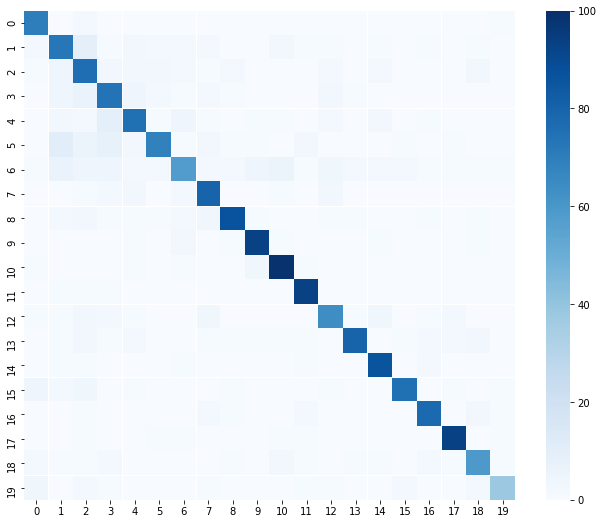

In [50]:
print(newsgroups1[0])
do_metrics(newsgroups1[1])

### 5.1.2 MNB with headers, footers, non-shuffled

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        73
           1       0.86      0.81      0.83       102
           2       0.84      0.84      0.84       103
           3       0.79      0.84      0.81       101
           4       0.94      0.91      0.93       104
           5       0.95      0.88      0.91       108
           6       0.92      0.83      0.87       110
           7       0.89      0.95      0.92        92
           8       0.99      0.96      0.98       106
           9       0.97      0.98      0.98       101
          10       0.91      1.00      0.95       107
          11       0.86      0.99      0.92        96
          12       0.91      0.87      0.89        84
          13       0.98      0.90      0.94       100
          14       0.89      0.98      0.93        92
          15       0.71      0.96      0.82        91
          16       0.80      0.94      0.86        88
          17       0.92    

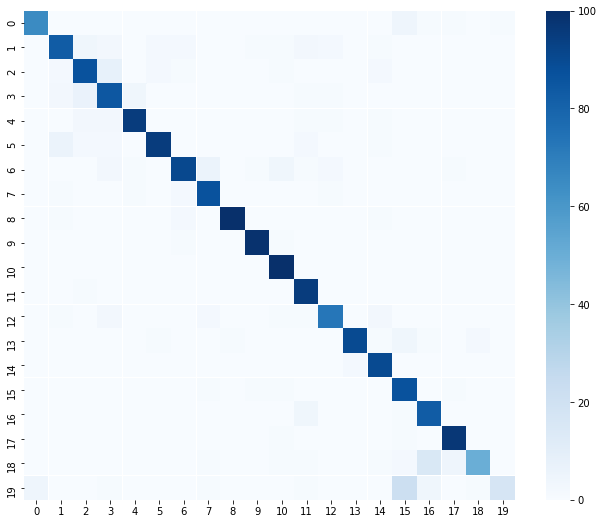

In [102]:
print(newsgroups1[2])
do_metrics(newsgroups1[3])

### 5.1.3 Random Forest without headers, footers, shuffled 80/20

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       157
           1       0.63      0.79      0.70       173
           2       0.70      0.84      0.77       198
           3       0.78      0.68      0.73       228
           4       0.81      0.85      0.83       185
           5       0.82      0.76      0.79       191
           6       0.61      0.86      0.71       184
           7       0.87      0.80      0.84       212
           8       0.88      0.85      0.87       179
           9       0.87      0.92      0.89       201
          10       0.89      0.95      0.92       218
          11       0.94      0.85      0.89       203
          12       0.82      0.64      0.72       195
          13       0.89      0.84      0.86       193
          14       0.86      0.87      0.86       178
          15       0.76      0.92      0.83       209
          16       0.80      0.83      0.82       200
          17       0.91    

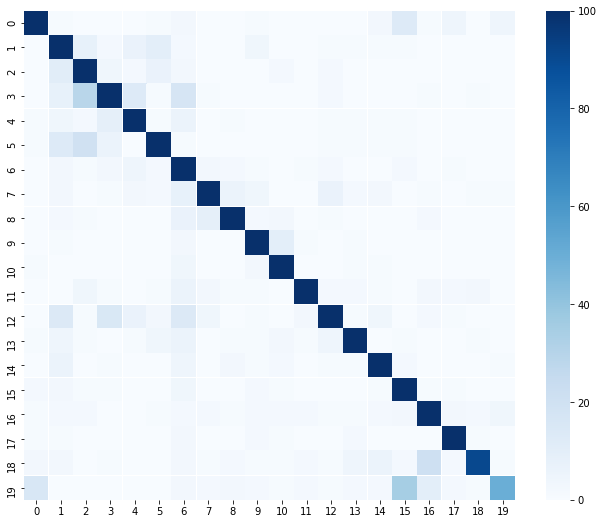

In [100]:
print(newsgroups_t20[10])
do_metrics(newsgroups_t20[11])

## 5.2 Detailed metrics: REUTERS

Only for those, which achieved highest accuracy

### 5.2.1 KNN with NaN 80/20

                 precision    recall  f1-score   support

                      0.59      0.87      0.70      2120
           wool       0.26      0.21      0.23       469
          trade       0.00      0.00      0.00        13
          sugar       0.00      0.00      0.00         1
           heat       0.50      0.09      0.15        11
         lumber       0.00      0.00      0.00         9
     iron-steel       1.00      0.25      0.40        12
         nickel       0.67      0.07      0.13        27
          crude       1.00      0.11      0.20        18
        housing       0.00      0.00      0.00         1
            tea       1.00      0.17      0.29         6
            ipi       0.83      0.29      0.43        17
         silver       0.00      0.00      0.00         2
            stg       0.30      0.18      0.22       112
          grain       0.00      0.00      0.00         1
         income       0.00      0.00      0.00         9
      meal-feed       0.92    

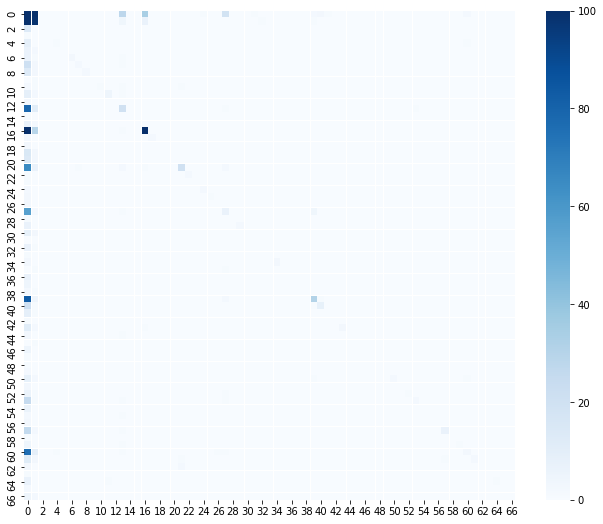

In [60]:
print(reuters_t20[0])
do_metrics(reuters_t20[1])

### 5.2.2 MNB default dataset, 90/10

                 precision    recall  f1-score   support

                      0.55      0.97      0.70      1037
            acq       1.00      0.04      0.07       227
           alum       0.00      0.00      0.00         7
            bop       0.00      0.00      0.00         6
        carcass       0.00      0.00      0.00         5
          cocoa       0.00      0.00      0.00         6
         coffee       0.00      0.00      0.00        11
         copper       0.00      0.00      0.00         8
           corn       0.00      0.00      0.00         4
         cotton       0.00      0.00      0.00         2
            cpi       0.00      0.00      0.00         9
          crude       1.00      0.02      0.04        55
            dlr       0.00      0.00      0.00        13
           earn       0.90      0.76      0.83       364
            gas       0.00      0.00      0.00         2
            gnp       0.00      0.00      0.00        14
           gold       0.00    

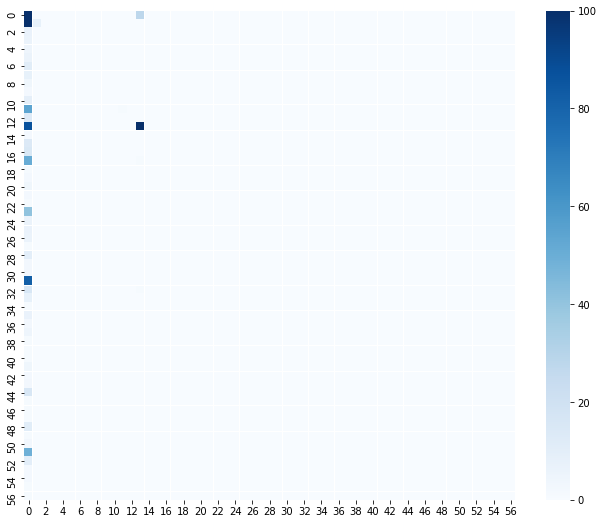

In [61]:
print(reuters[2])
do_metrics(reuters[3])

### 5.2.2 RF with NaN 80/20

                 precision    recall  f1-score   support

                      0.70      0.96      0.81      2120
            acq       0.90      0.61      0.73       469
           alum       1.00      0.15      0.27        13
         barley       0.00      0.00      0.00         1
            bop       1.00      0.09      0.17        11
        carcass       1.00      0.11      0.20         9
          cocoa       1.00      0.33      0.50        12
         coffee       0.86      0.22      0.35        27
         copper       1.00      0.28      0.43        18
           corn       0.00      0.00      0.00         1
         cotton       0.00      0.00      0.00         6
            cpi       0.67      0.35      0.46        17
            cpu       0.00      0.00      0.00         2
          crude       0.89      0.44      0.59       112
        cruzado       0.00      0.00      0.00         1
            dlr       0.33      0.11      0.17         9
           earn       0.94    

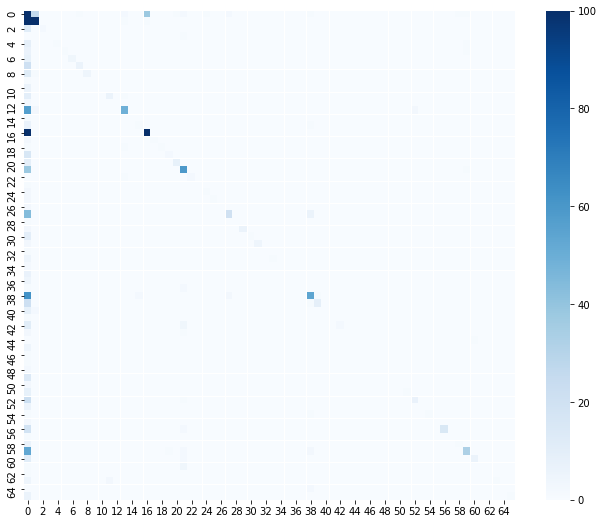

In [62]:
print(reuters_t20[10])
do_metrics(reuters_t20[11])

In [63]:
lazy

{'cr_kn': 0,
 'cm_kn': 1,
 'cr_nb': 2,
 'cm_nb': 3,
 'x_train': 4,
 'y_train': 5,
 'model_kn': 6,
 'model_nb': 7,
 'y_hat_kn': 8,
 'y_hat_nb': 9,
 'cr_rf': 10,
 'cm_rf': 11,
 'model_rf': 12,
 'y_hat_rf': 13,
 'x_test': 14,
 'y_test': 15}

## 4. Parameter tuning

**Hyperparameter search:** For hyperparameters a grid search was implemented. For both KNN and Multinomial NB most of the possible metrics were explored due to the fast nature of the chosen design. For Random Forest it was assumed the majority of trials will go 'NaN' due to incompatability of parameters, which proved to be true. However, in order not to burn the CPU, `n_jobs` parameter was chosen as 1 and training size was reduced to only 3000 units, as with two-fold cross-validation there were already 432 candidates with 864 fits for KNN. The results revealed that accuracy for both Random Forest Trees and Multinomial NB fluctuates about 10\%, whereas KNN relies heavily on hyperparameters, fluctuation up to 60\%.

**Generability:** the only un-generalisible part of the whole pipeline is data preprocessing. However, not all data is created equal - naturally, the preprocessing step will always differ. As regards to models itself, the most adaptive one proved to be Random Forest Trees, whereas KNN depended heavily on data preprocessing and randomness, thus, results fluctuated the most.

**Future design choices and ideas:** 1) as most of the data in Reuters data set is non-labeled, it would be interesting to see how a non-supervised or semi-supervised algorithm would perform on the data 2) I am still not sure how to deal with mutli-labels and would love to see the solution 3) would split data into train, test and validation 4) as the implementation of \path{pipe()} function allows it, would try out more models in order to educate myself through observations 5) would run hyperparameter tuning on fewer hyperparameters, but more options per one.

In [64]:
from sklearn.model_selection import GridSearchCV

# ----KNN ----

parameters_kn = {
    'vect__stop_words': ('english', None),
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__n_neighbors': (5, 7, 11),
    'clf__weights':('uniform', 'distance'),
    'clf__p':(1, 2),  
    'clf__metric': ('euclidean', 'manhattan', 'minkowski')
}

# ---- MULTINOMIAL NAIVE BAYES ----


parameters_nb = {
    'vect__stop_words': ('english', None),
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.1, 0.01, 0.001, 0.0001), 
    'clf__fit_prior':(True, False),
}

# ---- RANDOM FOREST ----

parameters_rf = {
    'vect__stop_words': ('english', None),
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__class_weight':('balanced', 'balanced_subsample', None),
    'clf__criterion':('gini', 'entropy'),
    'clf__min_samples_split': (2, 3, 4),
    'clf__min_samples_split': (1, 2, 3),
    'clf__n_estimators':(20, 50, 100, 200),
    'clf__warm_start':(True, False)
}

In [65]:
# chosen_model = newsgroups
chosen_model = newsgroups_t20
# chosen_model = newsgroups1
# chosen_model = newsgroups2

# chosen_model = reuters
# chosen_model = reuters_t20

In [66]:
lazy

{'cr_kn': 0,
 'cm_kn': 1,
 'cr_nb': 2,
 'cm_nb': 3,
 'x_train': 4,
 'y_train': 5,
 'model_kn': 6,
 'model_nb': 7,
 'y_hat_kn': 8,
 'y_hat_nb': 9,
 'cr_rf': 10,
 'cm_rf': 11,
 'model_rf': 12,
 'y_hat_rf': 13,
 'x_test': 14,
 'y_test': 15}

In [67]:
gs_kn = GridSearchCV(chosen_model[6], parameters_kn, cv=2, n_jobs=3, verbose=True)

# To change parameters:

# print('For the KN model available parameters are:\n')
# print('Parameters for the whole model pipeline:', gs_kn.get_params().keys())

# for i in gs_kn.get_params().keys():
#     if 'clf' in i:
#         print(i)

In [68]:
gs_nb = GridSearchCV(chosen_model[7], parameters_nb, cv=2, n_jobs=3, verbose=True)

# To change parameters:

# print('For the Multinomial Naive Bayes model available parameters are:\n')
# print('Parameters for the whole model pipeline:', gs_nb.get_params().keys())

# for i in gs_nb.get_params().keys():
#     if 'clf' in i:
#         print(i)

In [69]:
gs_rf = GridSearchCV(chosen_model[12], parameters_rf, cv=2, n_jobs=1, verbose=True)

# To change parameters:

print('For the Random Forest model available parameters are:\n')
# print('Parameters for the whole model pipeline:', gs_nb.get_params().keys())

for i in gs_rf.get_params().keys():
    if 'clf' in i:
        print(i)

For the Random Forest model available parameters are:

estimator__clf
estimator__clf__bootstrap
estimator__clf__ccp_alpha
estimator__clf__class_weight
estimator__clf__criterion
estimator__clf__max_depth
estimator__clf__max_features
estimator__clf__max_leaf_nodes
estimator__clf__max_samples
estimator__clf__min_impurity_decrease
estimator__clf__min_impurity_split
estimator__clf__min_samples_leaf
estimator__clf__min_samples_split
estimator__clf__min_weight_fraction_leaf
estimator__clf__n_estimators
estimator__clf__n_jobs
estimator__clf__oob_score
estimator__clf__random_state
estimator__clf__verbose
estimator__clf__warm_start


Source for the cell below: https://stackoverflow.com/questions/39977117/ipython-display-full-dataframe-in-new-tab/40878617

In [70]:
from IPython.display import HTML

def view(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))

In [71]:
start = timer()
gs_kn = gs_kn.fit(chosen_model[4][:3000], chosen_model[5][:3000])
end = timer()
print('Search executed in:', end-start)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  5.2min
[Parallel(n_jobs=3)]: Done 576 out of 576 | elapsed:  6.7min finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.6s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Search executed in: 404.0057876589999


In [72]:
print('Best achieved score:', gs_kn.best_score_, '\n')

print('With these params:\n', gs_kn.best_params_)

Best achieved score: 0.5700000000000001 

With these params:
 {'clf__metric': 'euclidean', 'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'uniform', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


In [84]:
results_df = pd.concat([pd.DataFrame(gs_kn.cv_results_["params"]),
                 pd.DataFrame(gs_kn.cv_results_["mean_test_score"], 
                              columns=["Accuracy"])],axis=1)

results_df

,clf__metric,clf__n_neighbors,clf__p,clf__weights,tfidf__use_idf,vect__ngram_range,vect__stop_words,Accuracy
0,euclidean,5,1,uniform,True,"(1, 1)",english,0.169000
1,euclidean,5,1,uniform,True,"(1, 1)",None,0.162333
2,euclidean,5,1,uniform,True,"(1, 2)",english,0.166667
3,euclidean,5,1,uniform,True,"(1, 2)",None,0.153333
4,euclidean,5,1,uniform,False,"(1, 1)",english,0.153333
...,...,...,...,...,...,...,...,...
283,minkowski,11,2,distance,True,"(1, 2)",None,0.397000
284,minkowski,11,2,distance,False,"(1, 1)",english,0.309333
285,minkowski,11,2,distance,False,"(1, 1)",None,0.222000
286,minkowski,11,2,distance,False,"(1, 2)",english,0.304000


In [85]:
view(results_df)

In [74]:
start = timer()
gs_nb = gs_nb.fit(chosen_model[4][:3000], chosen_model[5][:3000])
end = timer()
print('Search executed in:', end-start)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   28.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  2.1min finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.6s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
Search executed in: 127.8036241750001


In [75]:
print('Best achieved score:', gs_nb.best_score_, '\n')

print('With these params:\n', gs_nb.best_params_)

Best achieved score: 0.7593333333333333 

With these params:
 {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


In [97]:
results_df = pd.concat([pd.DataFrame(gs_nb.cv_results_["params"]),
                 pd.DataFrame(gs_nb.cv_results_["mean_test_score"], 
                              columns=["Accuracy"])],axis=1)
results_df

,clf__alpha,clf__fit_prior,tfidf__use_idf,vect__ngram_range,vect__stop_words,Accuracy
0,0.1000,True,True,"(1, 1)",english,0.759333
1,0.1000,True,True,"(1, 1)",None,0.720000
2,0.1000,True,True,"(1, 2)",english,0.749333
3,0.1000,True,True,"(1, 2)",None,0.676333
4,0.1000,True,True,"(1, 3)",english,0.746000
...,...,...,...,...,...,...
91,0.0001,False,False,"(1, 1)",None,0.712333
92,0.0001,False,False,"(1, 2)",english,0.718000
93,0.0001,False,False,"(1, 2)",None,0.695000
94,0.0001,False,False,"(1, 3)",english,0.718000


In [98]:
view(results_df)

In [77]:
start = timer()
gs_rf = gs_rf.fit(chosen_model[4][:3000], chosen_model[5][:3000])
end = timer()
print('Search executed in:', end-start)

Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  15.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  16.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  14.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  15.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  16.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  15.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  14.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  15.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  16.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  15.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  17.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  14.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  19.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  14.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  16.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  15.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  18.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


[Pipeline] ............... (step 3 of 3) Processing clf, total=  14.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  12.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  14.6s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   9.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipel

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   7.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   6.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   8.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   2.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.4s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  13.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  16.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.2s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   2.8s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.2s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.3s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.8s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipel

[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.9s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.0s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   4.1s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  10.5s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.0s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  11.7s
[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.1s
[Pipel

[Parallel(n_jobs=1)]: Done 2304 out of 2304 | elapsed: 485.7min finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=   1.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  41.0s
Search executed in: 8434.38369184


In [92]:
print('Best achieved score:', gs_rf.best_score_, '\n')

print('With these params:\n', gs_rf.best_params_)

Best achieved score: 0.6753333333333333 

With these params:
 {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'gini', 'clf__min_samples_split': 3, 'clf__n_estimators': 200, 'clf__warm_start': False, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}


In [94]:
results_df = pd.concat([pd.DataFrame(gs_rf.cv_results_["params"]),
                 pd.DataFrame(gs_rf.cv_results_["mean_test_score"], 
                              columns=["Accuracy"])],axis=1)
results_df

,clf__class_weight,clf__criterion,clf__min_samples_split,clf__n_estimators,clf__warm_start,tfidf__use_idf,vect__ngram_range,vect__stop_words,Accuracy
0,balanced,gini,1,20,True,True,"(1, 1)",english,NaN
1,balanced,gini,1,20,True,True,"(1, 1)",None,NaN
2,balanced,gini,1,20,True,True,"(1, 2)",english,NaN
3,balanced,gini,1,20,True,True,"(1, 2)",None,NaN
4,balanced,gini,1,20,True,False,"(1, 1)",english,NaN
...,...,...,...,...,...,...,...,...,...
1147,None,entropy,3,200,False,True,"(1, 2)",None,0.438667
1148,None,entropy,3,200,False,False,"(1, 1)",english,0.556667
1149,None,entropy,3,200,False,False,"(1, 1)",None,0.473333
1150,None,entropy,3,200,False,False,"(1, 2)",english,0.555667


In [95]:
view(results_df)